# **Image Captioning With LLaMA 3 and using CLIP for vision transformer**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics spacy
!python -q -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 210.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 230.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 187.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 146.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 182.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

### **Import files**

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint

import re
import os
import cv2
import copy
import math
import random
import warnings
import collections

import numpy as np
import matplotlib.pyplot as plt

import urllib.request as urllib

from PIL import Image
from google.colab.patches import cv2_imshow

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F

from torchmetrics.text import ROUGEScore

from torch.nn.utils.rnn import pad_sequence
from torchvision.transforms.v2 import (
    Compose,
    Resize,
    ToTensor,
    Normalize,
    RandomHorizontalFlip,
    RandomAffine,
    RandomAutocontrast
)

try:
    from torchvision.transforms.v2 import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.datasets.utils import download_and_extract_archive

import spacy
spacy = spacy.load("en_core_web_sm")

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [4]:
ANNOTATION_PATH = "experiment/dataset/Flickr8k.token.txt"
IMAGE_PATH = "experiment/dataset/Flicker8k_Dataset"

In [5]:
METRIC_TO_MONITOR = "val_loss"
METRIC_MODE       = "min"

In [6]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1867673678


In [7]:
START_TOKEN = "<sos>"
END_TOKEN = "<eos>"
PAD_TOKEN = "<pad>"
OOV_TOKEN = "<unk>"

In [8]:
MAX_SEQUENCE = 30
IMAGE_SIZE = 300

In [9]:
TEMPERATURE = 0.1
TOP_P = 0.9

In [10]:
NUM_HEAD = 32
NUM_KV_HEAD = 8
NUM_LAYER = 1
EMBED_DIM = 640
HEAD_DIM = EMBED_DIM // NUM_HEAD
ROPE_BASE = 10000
MLP_SCALE = 3.5
DROPOUT = math.sin(math.sqrt(math.e * math.pi))
EPS_NORM = 1e-5

In [11]:
MAX_EPOCH = 1
BATCH_SIZE = 128
LEARNING_RATE = 3.1e-4
REDUCE_LR_FACTOR = 0.69

In [12]:
MILESTONES = 1. / math.sqrt(MAX_EPOCH) * (
    np.array(
        [m for m in range(1, int(math.sqrt(MAX_EPOCH)))]
    )
)

## **Dataset**

### **Prepare**

In [13]:
DATASET_URL = {
    "image" : (
        "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
        "Flickr8k_Dataset.zip",
    ),
    "text"   : (
        "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",
        "Flickr8k_text.zip",
    ),
}

In [14]:
for dat in DATASET_URL.values():
    url, filename = dat
    download_and_extract_archive(
        url,
        "experiment/dataset",
        filename=filename,
    )
    os.remove(os.path.join("experiment/dataset", filename))

100%|██████████| 1.12G/1.12G [00:10<00:00, 109MB/s]


Extracting experiment/dataset/Flickr8k_Dataset.zip to experiment/dataset


100%|██████████| 2.34M/2.34M [00:00<00:00, 48.2MB/s]

Extracting experiment/dataset/Flickr8k_text.zip to experiment/dataset


### **Utils**

#### **Image Transform**

In [15]:
class ToRGB(object):
    def __call__(self, image):
        assert 'PIL' in str(type(image)), "Expected PIL Image"
        return image.convert("RGB")

In [16]:
TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=BICUBIC),
        ToRGB(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

TRANSFORM_AUGMENTATION = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=BICUBIC),
        ToRGB(),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        RandomHorizontalFlip(),
        RandomAutocontrast(p=0.25),
        RandomAffine(
            degrees=22.5,
            scale=(math.sqrt(0.5 * math.pi), math.sqrt(math.pi)),
            shear=5.,
        ),
    ]
)

#### **Tokenizer**

In [17]:
class Tokenizer(object):
    def __init__(self, freq_threshold=1):
        self.encoder = collections.defaultdict(lambda : 3)
        self.encoder[END_TOKEN] = 2
        self.encoder[START_TOKEN] = 1
        self.encoder[PAD_TOKEN] = 0

        self.freq_threshold = freq_threshold

        frequencies = dict()
        idx = len(self.encoder)

        with open(ANNOTATION_PATH) as captions:
            sentence_list = [
                line.rstrip("\n").split("\t")[-1].strip().lower()
                for line in captions.readlines()
            ]

        for sentence in sentence_list:
            tokenized_sentence = [
                tok.text.lower() for tok in spacy.tokenizer(sentence.strip())
            ]
            for word in tokenized_sentence:
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    idx += 1
                    self.encoder[word] = idx

        self.decoder = dict()
        self.decoder[0] = PAD_TOKEN
        self.decoder[1] = START_TOKEN
        self.decoder[2] = END_TOKEN
        self.decoder[3] = OOV_TOKEN
        for k, v in self.encoder.items():
            if v not in self.decoder:
                self.decoder[v] = k

    def __len__(self):
        assert len(self.encoder) == len(self.decoder)
        return len(self.encoder)

    def encode(self, text):
        numericalized_token = list()
        del_oov_token = False

        for token in spacy.tokenizer(text.strip()):
            if token.text.lower() not in self.encoder:
                del_oov_token = True

            numericalized_token.append(self.encoder[token.text.lower()])

            if del_oov_token:
                del self.encoder[token.text.lower()]
                del_oov_token = False

        return numericalized_token

    def decode(self, tokens):
        return " ".join([self.decoder[token] for token in tokens])

In [18]:
Tokenizer = Tokenizer()
print(f"Vocab size: {len(Tokenizer.decoder)}")

Vocab size: 8508


In [19]:
def tokenize(text):
    sos_token = Tokenizer.encoder[START_TOKEN]
    eos_token = Tokenizer.encoder[END_TOKEN]
    tokens = [sos_token] + Tokenizer.encode(text) + [eos_token]

    result = torch.full(
        (MAX_SEQUENCE,),
        Tokenizer.encoder[PAD_TOKEN],
        dtype=torch.long,
    )

    if len(tokens) > MAX_SEQUENCE:
        tokens = tokens[:MAX_SEQUENCE]
        tokens[-1] = eos_token

    result[:len(tokens)] = torch.tensor(tokens)

    return result.long()

#### **Image Captioning Dataset**

In [20]:
class Flickr8KDataset(data.Dataset):
    def __init__(self, split):
        assert split in ["train", "val", "test", "inference"]

        self.images = list()
        self.captions = list()

        with open(ANNOTATION_PATH) as caption_file:
            for line in caption_file.readlines():
                img_name, caption = line.rstrip("\n").split("\t")
                img_name = img_name.split("#")[0]
                img_name = os.path.join(IMAGE_PATH, img_name.strip())

                caption = caption.strip()
                tokens = [tok.text.lower() for tok in spacy.tokenizer(caption)]

                if img_name.endswith("jpg"):
                    self.images.append(img_name)
                    self.captions.append(caption)

        random.seed(SEED)
        random.shuffle(self.images)

        random.seed(SEED)
        random.shuffle(self.captions)

        n_data = len(self.images)

        if split == "train":
            self.transform = TRANSFORM_AUGMENTATION
            start = 0
            end = int(0.8 * n_data)
        else:
            self.transform = TRANSFORM
            if split == "val":
                start = int(0.8 * n_data)
                end = int(0.9 * n_data)
            else:
                start = int(0.9 * n_data)
                end = n_data

        self.images = self.images[start:end]
        self.captions = self.captions[start:end]

        self.split = split

    def raw_image(self, index):
        assert self.split == "inference"
        return Image.open(self.images[index]).convert("RGB")

    def inference_data(self, index):
        assert self.split == "inference"
        image = self.transform(Image.open(self.images[index]))
        return image

    def __len__(self):
        assert len(self.images) == len(self.captions)
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(Image.open(self.images[index]))
        caption = tokenize(self.captions[index])
        return image, caption

#### **Collate Function**

In [21]:
class CollateFunction(object):
    def __init__(self, pad_idx=Tokenizer.encoder[PAD_TOKEN]):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)

        captions = [item[1] for item in batch] + [torch.randn(MAX_SEQUENCE + 1)]
        captions = pad_sequence(
            captions,
            batch_first=True,
            padding_value=self.pad_idx,
        )[:-1, ...]
        return images, captions.long()

In [22]:
CollateFunction = CollateFunction()

### **Load**

In [23]:
TrainDataset = Flickr8KDataset('train')
ValDataset = Flickr8KDataset('val')
TestDataset = Flickr8KDataset('test')

## **Model**

### **Utils**

In [24]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val.detach() if isinstance(val, torch.Tensor) else torch.tensor(val))

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

### **Module**

In [25]:
class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.scale

In [26]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(
        self,
        dim,
        max_seq_len=4096,
        base=10_000,
    ):
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_seq_len = max_seq_len
        self._rope_init()

    def _rope_init(self):
        theta = 1.0 / (
            self.base
            ** (torch.arange(0, self.dim, 2)[: (self.dim // 2)].float() / self.dim)
        )
        self.register_buffer(
            "theta",
            theta.to("cuda" if torch.cuda.is_available() else "cpu"),
            persistent=False,
        )
        self.build_rope_cache(self.max_seq_len)

    def build_rope_cache(self, max_seq_len = 4096):
        seq_idx = torch.arange(
            max_seq_len, dtype=self.theta.dtype, device=self.theta.device
        )

        idx_theta = torch.einsum("i, j -> ij", seq_idx, self.theta).float()

        cache = torch.stack([torch.cos(idx_theta), torch.sin(idx_theta)], dim=-1)
        self.register_buffer("cache", cache, persistent=False)

    def forward(self, x, input_pos=None):

        seq_len = x.size(1)

        rope_cache = (
            self.cache[:seq_len] if input_pos is None else self.cache[input_pos]
        )

        xshaped = x.float().reshape(*x.shape[:-1], -1, 2)
        rope_cache = rope_cache.view(1, xshaped.size(1), 1, xshaped.size(3), 2)

        x_out = torch.stack(
            [
                xshaped[..., 0] * rope_cache[..., 0]
                - xshaped[..., 1] * rope_cache[..., 1],
                xshaped[..., 1] * rope_cache[..., 0]
                + xshaped[..., 0] * rope_cache[..., 1],
            ],
            -1,
        )

        x_out = x_out.flatten(3)
        return x_out.type_as(x)

In [27]:
class KVCache(nn.Module):

    def __init__(
        self,
        max_batch_size,
        max_seq_len,
        num_heads,
        head_dim,
        dtype=torch.float32,
    ):
        super().__init__()
        cache_shape = (max_batch_size, num_heads, max_seq_len, head_dim)
        self.register_buffer(
            "k_cache",
            torch.zeros(
                cache_shape,
                dtype=dtype,
                device="cuda" if torch.cuda.is_available() else "cpu"
            ),
            persistent=False,
        )
        self.register_buffer(
            "v_cache",
            torch.zeros(
                cache_shape,
                dtype=dtype,
                device="cuda" if torch.cuda.is_available() else "cpu"
            ),
            persistent=False,
        )
        self.max_batch_size = max_batch_size

    def update(self, input_pos, k_val, v_val):
        assert input_pos.shape[0] == k_val.shape[2]

        k_out = self.k_cache
        v_out = self.v_cache
        k_out[:, :, input_pos] = k_val
        v_out[:, :, input_pos] = v_val

        return k_out, v_out

In [28]:
class CausalSelfAttention(nn.Module):
    def __init__(
        self,
        embed_dim,
        num_heads,
        num_kv_heads,
        head_dim,
        q_proj,
        k_proj,
        v_proj,
        output_proj,
        pos_embeddings,
        kv_cache=None,
        max_seq_len=4096,
        attn_dropout=0.0,
    ):
        super().__init__()
        if num_heads % num_kv_heads != 0:
            raise ValueError(
                f"num_heads ({num_heads}) must be divisible by "
                f"num_kv_heads ({num_kv_heads})"
            )

        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by "
                f"num_heads ({num_heads})"
            )

        if attn_dropout < 0 or attn_dropout > 1:
            raise ValueError(f"attn_dropout ({embed_dim}) must be between 0.0 and 1.0")

        self.num_heads = num_heads
        self.num_kv_heads = num_kv_heads
        self.embed_dim = embed_dim
        self.attn_dropout = attn_dropout
        self.head_dim = head_dim
        self.max_seq_len = max_seq_len

        self.kv_cache = kv_cache
        self.q_proj = q_proj
        self.k_proj = k_proj
        self.v_proj = v_proj
        self.output_proj = output_proj
        self.pos_embeddings = pos_embeddings

    def forward(self, x, y=None, mask=None, input_pos=None):

        bsz, seq_len, _ = x.shape

        if seq_len > self.max_seq_len:
            raise ValueError(
                f"seq_len ({seq_len}) of input tensor should be smaller "
                f"than max_seq_len ({self.max_seq_len})"
            )

        if y is None:
            y = x

        kv_seq_len = y.shape[1]

        q = self.q_proj(x)
        k = self.k_proj(y)
        v = self.v_proj(y)

        q_per_kv = self.num_heads // self.num_kv_heads

        q = q.view(bsz, seq_len, self.num_kv_heads, q_per_kv, self.head_dim)
        k = k.view(bsz, kv_seq_len, self.num_kv_heads, 1, self.head_dim)
        v = v.view(bsz, kv_seq_len, self.num_kv_heads, 1, self.head_dim)

        if self.num_heads != self.num_kv_heads:
            k = k.expand(bsz, kv_seq_len, self.num_kv_heads, q_per_kv, self.head_dim)
            v = v.expand(bsz, kv_seq_len, self.num_kv_heads, q_per_kv, self.head_dim)

        q = q.reshape(bsz, seq_len, -1, self.head_dim)
        k = k.reshape(bsz, kv_seq_len, -1, self.head_dim)
        v = v.reshape(bsz, kv_seq_len, -1, self.head_dim)

        q = self.pos_embeddings(q, input_pos)
        k = self.pos_embeddings(k, input_pos)


        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        if self.kv_cache is not None:
            k, v = self.kv_cache.update(input_pos, k, v)

        output = nn.functional.scaled_dot_product_attention(
            q,
            k,
            v,
            attn_mask=mask,
            dropout_p=self.attn_dropout,
            is_causal=self.kv_cache is None,
        )

        output = output.transpose(1, 2).contiguous().view(bsz, seq_len, -1)
        return self.output_proj(output)

In [29]:
def _get_clones(module, n):
    return nn.ModuleList([copy.deepcopy(module) for i in range(n)])

In [30]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, attn, mlp, sa_norm, mlp_norm):
        super().__init__()
        self.attn = attn
        self.sa_norm = sa_norm
        self.mlp = mlp
        self.mlp_norm = mlp_norm

    def forward(self, x, mask=None, input_pos=None):
        residual = x
        x = self.sa_norm(x)
        x = self.attn(x, input_pos=input_pos, mask=mask)
        x = x + residual

        residual = x
        x = self.mlp_norm(x)
        x = self.mlp(x)
        x = x + residual
        return x

In [31]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        feature_extractor,
        layer,
        num_layers,
        max_seq_len,
        num_heads,
        head_dim,
        norm,
    ):
        super().__init__()

        self.feature_extractor = feature_extractor
        self.layers = _get_clones(layer, num_layers)
        self.norm = norm
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.causal_mask = None

    def setup_caches(self, max_batch_size, dtype=torch.float32):
        for layer in self.layers:
            layer.attn.kv_cache = KVCache(
                max_batch_size=max_batch_size,
                max_seq_len=self.max_seq_len,
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                dtype=dtype,
            )
        self.causal_mask = torch.tril(
            torch.ones(
                self.max_seq_len,
                self.max_seq_len,
                dtype=torch.bool,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
        )

    def clear_caches(self):
        for layer in self.layers:
            layer.attn.kv_cache = None
        self.causal_mask = None

    def forward(self, pixel_values, input_pos=None):

        batch_size = pixel_values.shape[0]

        features = self.feature_extractor(pixel_values).view(batch_size, 1, -1)

        mask = None
        if self.causal_mask is not None:
            if input_pos is None:
                raise ValueError(
                    "Caches are setup, but the position of input token is missing"
                )
            mask = self.causal_mask[None, None, input_pos]

        for layer in self.layers:
            features = layer(features, mask, input_pos)
        return self.norm(features).float()


In [32]:
import torch
import torchvision.transforms as transforms
from PIL import Image

class CLIPImageEncoder(nn.Module):

    def __init__(self, embed_dim=EMBED_DIM, freeze=True):
        super().__init__()
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

        if freeze:
            for param in self.clip_model.parameters():
                param.requires_grad = False

        self.proj = nn.Linear(512, embed_dim, bias=False)

    def forward(self, images):

        device = next(self.clip_model.parameters()).device
        if isinstance(images, torch.Tensor):
          images = images* 0.5 + 0.5
          images= images.clamp(0,1)
          images = [transforms.ToPILImage()(img) for img in images]
        inputs = self.processor(images=images, return_tensors="pt", padding=True)
        for k, v in inputs.items():
            inputs[k] = v.to(device)

        with torch.no_grad():
            clip_feats = self.clip_model.get_image_features(**inputs)  # (B, 512)

        out = self.proj(clip_feats)
        out = out.unsqueeze(1)
        return out

In [33]:
class TransformerDecoderLayer(nn.Module):

    def __init__(self, attn1, attn2, mlp, sa_norm_x1, sa_norm_x2, mlp_norm):
        super().__init__()
        self.sa_norm_x1 = sa_norm_x1
        self.sa_norm_x2 = sa_norm_x2
        self.attn1 = attn1
        self.attn2 = attn2
        self.mlp_norm = mlp_norm
        self.mlp = mlp

    def forward(self, x, y, mask=None, input_pos=None):
        attn_out = self.attn1(self.sa_norm_x1(x), mask=mask, input_pos=input_pos)

        h = attn_out + x

        attn_out = self.attn2(
            self.sa_norm_x2(h),
            y,
            mask=mask,
            input_pos=input_pos,
        )

        h = attn_out + h

        mlp_out = self.mlp(self.mlp_norm(h))

        out = h + mlp_out
        return out

In [34]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        tok_embedding,
        layer,
        num_layers,
        max_seq_len,
        num_heads,
        head_dim,
        norm,
        output,
    ):
        super().__init__()

        self.tok_embedding = tok_embedding
        self.layers = _get_clones(layer, num_layers)
        self.norm = norm
        self.output = output
        self.max_seq_len = max_seq_len
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.causal_mask = None

    def setup_caches(self, max_batch_size, dtype=torch.float32):
        for layer in self.layers:
            layer.attn1.kv_cache = KVCache(
                max_batch_size=max_batch_size,
                max_seq_len=self.max_seq_len,
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                dtype=dtype,
            )
            layer.attn2.kv_cache = KVCache(
                max_batch_size=max_batch_size,
                max_seq_len=self.max_seq_len,
                num_heads=self.num_heads,
                head_dim=self.head_dim,
                dtype=dtype,
            )

        self.causal_mask = torch.tril(
            torch.ones(
                self.max_seq_len,
                self.max_seq_len,
                dtype=torch.bool,
                device="cuda" if torch.cuda.is_available() else "cpu"
            )
        )

    def clear_caches(self):
        for layer in self.layers:
            layer.attn1.kv_cache = None
            layer.attn2.kv_cache = None
        self.causal_mask = None

    def forward(self, tokens, enc, input_pos=None):

        bsz = tokens.shape[0]

        h = self.tok_embedding(tokens)

        enc = enc.view(bsz, 1, -1)

        mask = None
        if self.causal_mask is not None:
            if input_pos is None:
                raise ValueError(
                    "Caches are setup, but the position of input token is missing"
                )

            mask = self.causal_mask[None, None, input_pos]

        for layer in self.layers:
            h = layer(h, enc, mask, input_pos)

        h = self.norm(h)

        output = self.output(h).float()
        return output

In [35]:
class FeedForward(nn.Module):
    def __init__(
        self,
        *,
        gate_proj,
        down_proj,
        up_proj,
        activation=nn.SiLU(),
    ):
        super().__init__()
        self.w1 = gate_proj
        self.w2 = down_proj
        self.w3 = up_proj
        self.activation = activation

    def forward(self, x):
        return self.w2(self.activation(self.w1(x)) * self.w3(x))

In [36]:
import torch
import torch.nn as nn
import timm

### **Wrapper**

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import re
import numpy as np
import pytorch_lightning as L
import torch.optim as optim
from torch.utils import data
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel


import pytorch_lightning as pl

class ImageCaptioning(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = MAX_EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        MLP = FeedForward(
            gate_proj=nn.Linear(EMBED_DIM, int(EMBED_DIM * MLP_SCALE), bias=False),
            down_proj=nn.Linear(int(EMBED_DIM * MLP_SCALE), EMBED_DIM, bias=False),
            up_proj=nn.Linear(EMBED_DIM, int(EMBED_DIM * MLP_SCALE), bias=False),
        )

        FEATURE_EXTRACTOR = CLIPImageEncoder(
            embed_dim=EMBED_DIM,
            freeze=True
        )
        SELF_ATTENTION = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=RotaryPositionalEmbedding(
                dim=HEAD_DIM,
                max_seq_len=1,
                base=ROPE_BASE,
            ),
            max_seq_len=1,
            attn_dropout=DROPOUT,
        )

        ENCODER_LAYER = TransformerEncoderLayer(
            attn=SELF_ATTENTION,
            mlp=copy.deepcopy(MLP),
            sa_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            mlp_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
        )

        self.encoder = TransformerEncoder(
            feature_extractor=FEATURE_EXTRACTOR,
            layer=ENCODER_LAYER,
            num_layers=NUM_LAYER,
            max_seq_len=MAX_SEQUENCE,
            num_heads=NUM_HEAD,
            head_dim=HEAD_DIM,
            norm=RMSNorm(EMBED_DIM, eps=EPS_NORM),
        )
        TOKEN_EMBEDDING = nn.Embedding(len(Tokenizer.decoder), EMBED_DIM)

        ROPE = RotaryPositionalEmbedding(
            dim=HEAD_DIM,
            max_seq_len=MAX_SEQUENCE,
            base=ROPE_BASE,
        )

        SELF_ATTENTION_1 = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=ROPE,
            max_seq_len=MAX_SEQUENCE,
            attn_dropout=DROPOUT,
        )

        SELF_ATTENTION_2 = CausalSelfAttention(
            embed_dim=EMBED_DIM,
            num_heads=NUM_HEAD,
            num_kv_heads=NUM_KV_HEAD,
            head_dim=HEAD_DIM,
            q_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            k_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            v_proj=nn.Linear(EMBED_DIM, NUM_KV_HEAD * HEAD_DIM, bias=False),
            output_proj=nn.Linear(EMBED_DIM, EMBED_DIM, bias=False),
            pos_embeddings=ROPE,
            max_seq_len=MAX_SEQUENCE,
            attn_dropout=DROPOUT,
        )

        DECODER_LAYER = TransformerDecoderLayer(
            attn1=SELF_ATTENTION_1,
            attn2=SELF_ATTENTION_2,
            mlp=copy.deepcopy(MLP),
            sa_norm_x1=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            sa_norm_x2=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
            mlp_norm=RMSNorm(dim=EMBED_DIM, eps=EPS_NORM),
        )

        OUT_PROJECTION = nn.Linear(EMBED_DIM, len(Tokenizer.decoder), bias=False)

        self.decoder = TransformerDecoder(
            tok_embedding=TOKEN_EMBEDDING,
            layer=DECODER_LAYER,
            num_layers=NUM_LAYER,
            max_seq_len=MAX_SEQUENCE,
            num_heads=NUM_HEAD,
            head_dim=HEAD_DIM,
            norm=RMSNorm(EMBED_DIM, eps=EPS_NORM),
            output=OUT_PROJECTION,
        )

        self.automatic_optimization = False

        self.train_loss = []
        self.val_loss = []

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.test_rogue = ROUGEScore()
        self.sanity_check_counter = 1

    def forward(self, image, caption):
        image_feature = self.encoder(pixel_values=image)
        return self.decoder(caption, image_feature)

    def captionize(self, image, temperature=TEMPERATURE, top_p=TOP_P):
        assert image.shape[0] == 1

        self.encoder.setup_caches(max_batch_size=1)
        encoder_feat = self.encoder(
            pixel_values=image,
            input_pos=torch.tensor([0], device=self.device),
        )
        self.encoder.clear_caches()

        self.decoder.setup_caches(max_batch_size=1)

        pred_token = Tokenizer.encoder[START_TOKEN]
        token = [pred_token] + [Tokenizer.encoder[PAD_TOKEN]] * MAX_SEQUENCE

        for index in range(MAX_SEQUENCE):
            caption = torch.LongTensor([pred_token]).unsqueeze(0).to(self.device)

            pred_logits = self.decoder(
                caption,
                encoder_feat,
                input_pos=torch.tensor([index], device=self.device),
            )

            if temperature > 0:
                pred_probs = (pred_logits / temperature).softmax(-1)[0]
                psort, pidx = torch.sort(pred_probs, dim=-1, descending=True)
                psum = torch.cumsum(psort, dim=-1)
                psort[psum - psort > top_p] = 0.0
                psort.div_(psort.sum(dim=-1, keepdim=True))
                next_token = torch.multinomial(psort, 1)
                next_token = torch.gather(pidx, -1, next_token).transpose(0, 1)
            else:
                next_token = pred_logits.softmax(-1).argmax(2)

            pred_token = next_token.item()
            token[index + 1] = pred_token

            if pred_token == Tokenizer.encoder[END_TOKEN]:
                break

        self.decoder.clear_caches()

        return self.postprocess_text(Tokenizer.decode(token))

    def postprocess_text(self, text):
        text = text.replace(START_TOKEN, "")
        text = text.replace(END_TOKEN, "")
        text = text.replace(PAD_TOKEN, "")
        text = re.sub(r"\s([,.!?])", r"\1", text)
        text = ". ".join(s.strip().capitalize() for s in text.split("."))
        return text

    def training_step(self, batch, batch_nb):
        image, caption = batch

        pred = self(image, caption[:, :-1])
        pred = pred.view(-1, pred.shape[-1])
        caption_shifted = caption[:, 1:].reshape(-1)

        loss = F.cross_entropy(pred, caption_shifted, ignore_index=Tokenizer.encoder[PAD_TOKEN])

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(loss)
        torch.nn.utils.clip_grad_norm_(
            self.parameters(),
            math.log2(math.sqrt(math.e * math.tau) * math.pi),
        )
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.train_loss_recorder.update(loss.item())

    def on_train_epoch_end(self):
        sch = self.lr_schedulers()
        sch.step()
        self.train_loss.append(self.train_loss_recorder.show())
        self.train_loss_recorder = AvgMeter()

    def validation_step(self, batch, batch_nb):
        image, caption = batch

        pred = self(image, caption[:, :-1])
        pred = pred.view(-1, pred.shape[-1])
        caption_shifted = caption[:, 1:].reshape(-1)

        loss = F.cross_entropy(pred, caption_shifted, ignore_index=Tokenizer.encoder[PAD_TOKEN])

        if self.sanity_check_counter == 0:
            self.log("val_loss", loss, prog_bar=True)
            self.val_loss_recorder.update(loss.item())

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            loss = self.val_loss_recorder.show()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                str_report = f"[{MODEL_NAME}] Learning Rate Changed: {lr_now_}"
                str_report += f"- Epoch: {self.current_epoch}"
                print(str_report)
            self.val_loss.append(loss)
            self.val_loss_recorder = AvgMeter()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        image, caption = batch
        N_BATCH = image.shape[0]

        rogue1_fmeasure = []
        for idx in range(N_BATCH):
            pred = self.captionize(image[idx].unsqueeze(0))
            target = self.postprocess_text(
                Tokenizer.decode(
                    caption[idx].cpu().detach().numpy().tolist()
                )
            )
            val = self.test_rogue(pred, target)["rouge1_fmeasure"].cpu().detach().numpy().tolist()
            rogue1_fmeasure.append(val)

        mean_val = np.array(rogue1_fmeasure).mean()
        self.log("ROGUE-1 F-measure", mean_val, prog_bar=True, logger=True)

    def on_train_end(self):
        img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(img_file)
        plt.clf()

    def train_dataloader(self):
        return data.DataLoader(
            TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=CollateFunction,
            num_workers=2,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=CollateFunction,
            num_workers=2,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return data.DataLoader(
            TestDataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=CollateFunction,
            num_workers=2,
            persistent_workers=True,
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), self.lr)
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.MultiStepLR(
                optimizer,
                milestones=[int(self.max_epoch * ms) for ms in MILESTONES],
                gamma=REDUCE_LR_FACTOR,
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]


In [38]:
MODEL_NAME = ImageCaptioning.__name__
MODEL = ImageCaptioning()
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    f"model/{MODEL_NAME}_best.ckpt",
)
LAST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model/last.ckpt",
)

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## **Training**

In [39]:
import os
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl

def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)

    model = ImageCaptioning()
    print(f"Model type: {type(model)}")
    print(f"Is instance of LightningModule: {isinstance(model, pl.LightningModule)}")

    callbacks = []

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
        save_last=True,
    )
    callbacks.append(checkpoint)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=True,
        callbacks=callbacks,
        log_every_n_steps=5,
    )

    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()


INFO:lightning_fabric.utilities.seed:Seed set to 1867673678


ImageCaptioning


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Model type: <class '__main__.ImageCaptioning'>
Is instance of LightningModule: True


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | TransformerEncoder | 156 M  | train
1 | decoder    | TransformerDecoder | 17.2 M | train
2 | test_rogue | ROUGEScore         | 0      | train
----------------------------------------------------------
22.9 M    Trainable params
151 M     Non-trainable params
174 M     Total params
696.693   Total estimated model params size (MB)
45        Modules in train mode
306       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[ImageCaptioning] Learning Rate Changed: 0.00031- Epoch: 0


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


<Figure size 640x480 with 0 Axes>

## **Testing**

In [40]:
def _test_loop():
    trainer = Trainer(accelerator='auto', logger=False)
    model = ImageCaptioning.load_from_checkpoint(BEST_MODEL_PATH)
    trainer.test(
        model=model,
        ckpt_path=LAST_MODEL_PATH if os.path.exists(LAST_MODEL_PATH) else None,
    )

_test_loop()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at experiment/model/last.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at experiment/model/last.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     ROGUE-1 F-measure     │    0.3151441514492035     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

### **Utils**

In [41]:
INFERENCE_SAMPLE = 9
MAX_CHAR = 50

### **Initialize**

In [45]:
model = ImageCaptioning.load_from_checkpoint(LAST_MODEL_PATH) # Call load_from_checkpoint on the class, not the instance
model.eval()

InferenceDataset = Flickr8KDataset('inference')

### **Result**

#### **From Dataset**

<Figure size 640x480 with 0 Axes>

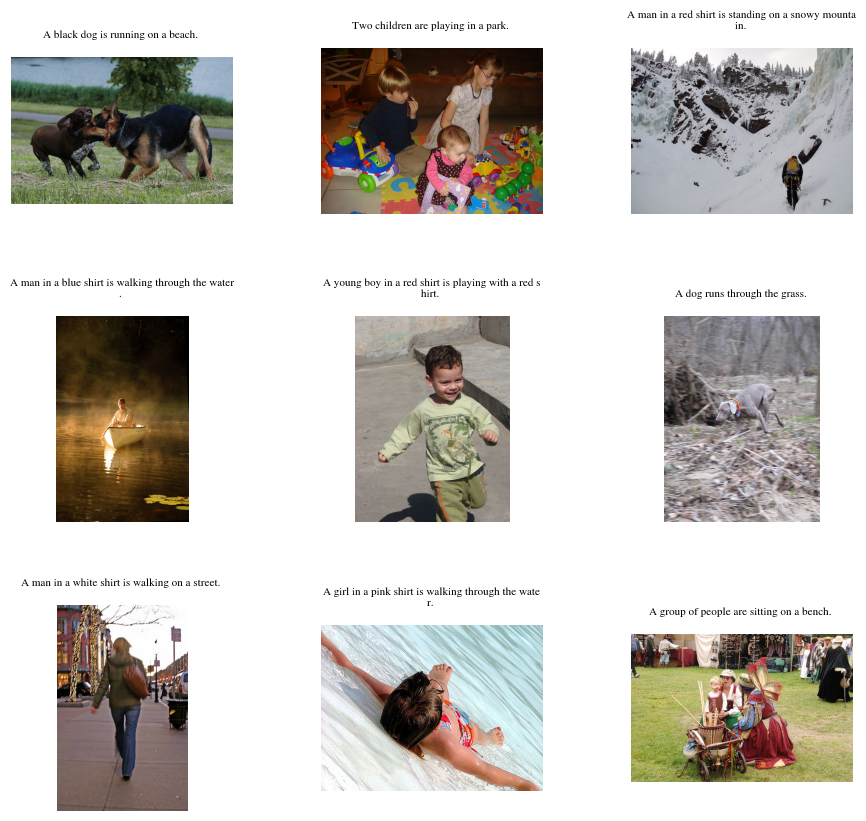

In [46]:
plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

N_SAMPLE = len(InferenceDataset)
SELECTED_SAMPLE = [
    random.randint(0, N_SAMPLE - 1) for _ in range(INFERENCE_SAMPLE)
]

for index, sample_idx in enumerate(SELECTED_SAMPLE):
    image = InferenceDataset.inference_data(sample_idx)
    image = image.to(
        "cuda" if torch.cuda.is_available() else "cpu"
    ).unsqueeze(0)

    caption = model.captionize(image)
    image = np.array(InferenceDataset.raw_image(sample_idx))

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)

    ax = fig.add_subplot(
        int(math.sqrt(INFERENCE_SAMPLE)),
        int(math.sqrt(INFERENCE_SAMPLE)),
        index + 1,
    )
    ax.imshow(image.copy().astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

#### **Testing the model on an Image**

In [49]:
INPUT_URL = "https://res.cloudinary.com/det80otgu/image/upload/v1741545931/Pngtree_vector_illustration_of_a_little_15723634_2_pdqde6.png"


def show_result():
    image_raw = cv2.cvtColor(
        cv2.imdecode(
            np.asarray(
                bytearray(urllib.urlopen(INPUT_URL).read()),
                dtype=np.uint8,
            ),
            -1,
        ),
        cv2.COLOR_BGR2RGB,
    )

    image = (
        TRANSFORM(
            Image.fromarray(
                image_raw.copy(),
                "RGB",
            )
        )
        .to("cuda" if torch.cuda.is_available() else "cpu")
        .unsqueeze(0)
    )

    caption = model.captionize(image)

    title = [
        f"{caption[(cline * MAX_CHAR):((cline + 1) * MAX_CHAR)]}\n"
        for cline in range(math.ceil(len(caption) / MAX_CHAR))
    ]
    title = "".join(title)
    plt.figure()
    plt.imshow(image_raw.copy())
    plt.title(title)
    plt.axis("off")
    plt.show()

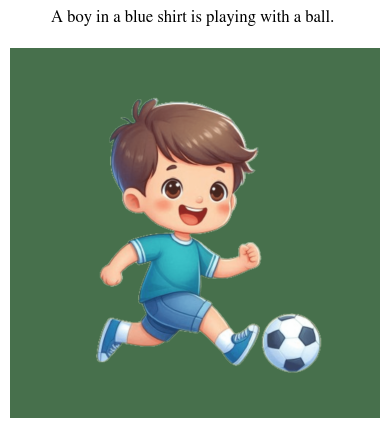

In [50]:
show_result()